Workflow:
0.libraries & device-agnostic
1.data acqusition
2.data preparation
3. transforming data
4. loading data with ImageFolder
5. loading image data with a custom Dataset
6.data augmentation
7. Model 0: TinyVGG without data augmmentation
8. explore loss curves
9.Model 1 TinyVGG with data augmentation
10. model results comparison
11. prediction on a custom image



In [1]:
import torch
from torch import nn

1. Data acqusition

In [2]:
import requests
import zipfile
from pathlib import Path
#setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
#check image folder existence, if not create one&download&prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    #download pizza, steak,sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak & sushi data...")
        f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...<<don't start feeling hungry though:)")
        zip_ref.extractall(image_path)


data\pizza_steak_sushi directory exists.


2. Data Preparation

In [3]:
#inspect contents of the data dir
import os 
def walk_through_dir(dir_path):
    for dirpath,dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}.")
        #print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [4]:
walk_through_dir(image_path)

There are 2 directories and 0images in 'data\pizza_steak_sushi.
There are 3 directories and 0images in 'data\pizza_steak_sushi\test.
There are 0 directories and 25images in 'data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19images in 'data\pizza_steak_sushi\test\steak.
There are 0 directories and 31images in 'data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0images in 'data\pizza_steak_sushi\train.
There are 0 directories and 78images in 'data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75images in 'data\pizza_steak_sushi\train\steak.
There are 0 directories and 72images in 'data\pizza_steak_sushi\train\sushi.


In [5]:
#setting up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


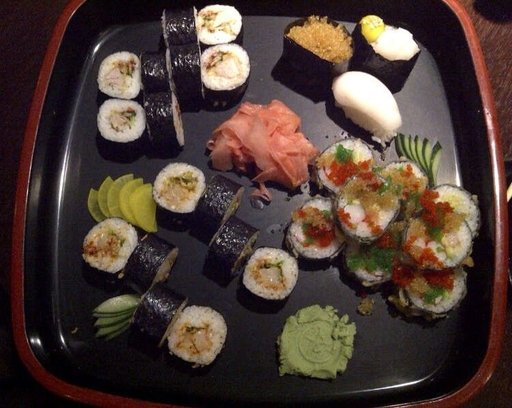

In [6]:
#2.1 Visualize an image
import random
from PIL import Image
random.seed(42)
#1.getting all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) #* means "any combination"
#2. get randomimage path
random_image_path = random.choice(image_path_list)
#3.get the name of the dir where image is stored
image_class = random_image_path.parent.stem
#4. Open image
img = Image.open(random_image_path)
#5. metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

3. Transforming data


goal = transform images to tensors and 
manipulate sizes and orientation
image[256,256,3] -->> image[64,64,3] #16x lesser pixels

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
#Image transform
data_transform = transforms.Compose([
    #resizing the images to 64 x 64
    transforms.Resize(size=(64, 64)),
    #randomly flip images horizontally
    transforms.RandomHorizontalFlip(p=0.5), #flip probability
    #turning image into a torch.Tensor
    transforms.ToTensor() #also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    
])

In [9]:
import matplotlib.pyplot as plt

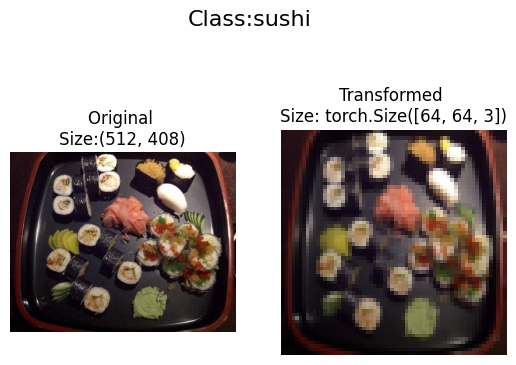

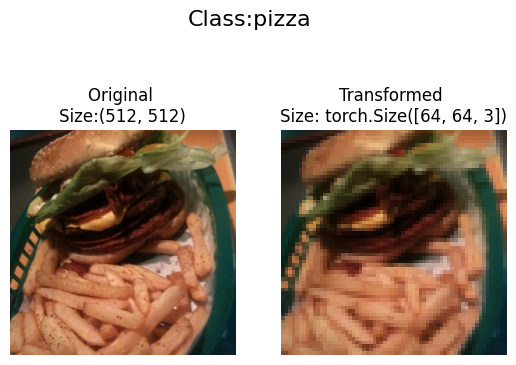

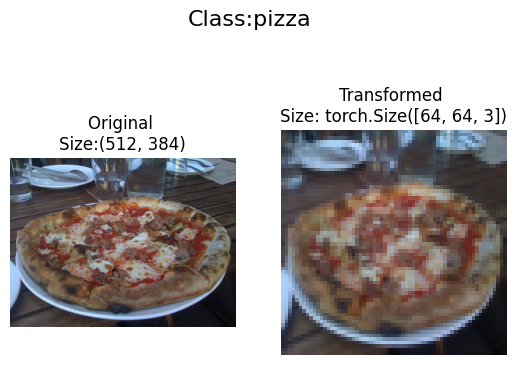

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize:{f.size}")
            ax[0].axis("off")
            #transform and plot image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class:{image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list,transform=data_transform, n=3)



4. Option 1:loading Image Data using ImageFolder


turn image data into a dataset that PyTorch can use

In [11]:
#using ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform= None)
test_data = datasets.ImageFolder(root=test_dir, transform = data_transform)
print(f"Train data:\n{train_data}\n Test data:\n {test_data}")


Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
 Test data:
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
#check class names as a list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [13]:
#as a dictionary
class_dict = train_data.class_to_idx
class_dict


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
#checking lenggths
len(train_data), len(test_data)

(225, 75)

In [15]:
#view images and labels (indexed)
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image label:{label}")
print(f"label datatype:{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) ->[color_channels,height,width]
Image permute shape: torch.Size([64, 64, 3]) -> [height,width,color_channel]


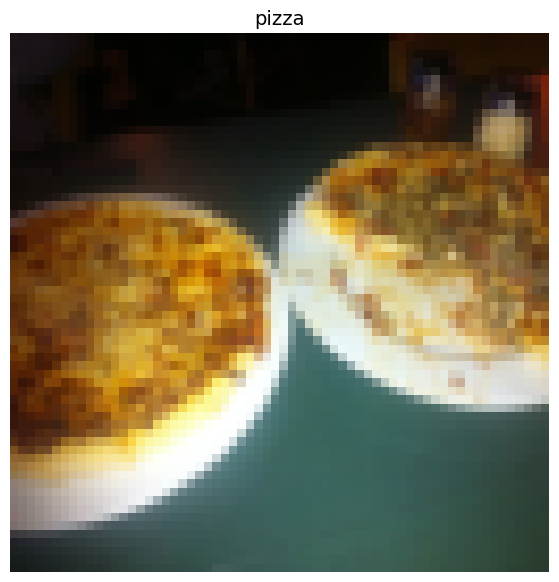

In [16]:
#rearranging  the order of dimensions
img_permute = img.permute(1,2,0)
#print out diff shapes
print(f"Original shape: {img.shape} ->[color_channels,height,width]")
print(f"Image permute shape: {img_permute.shape} -> [height,width,color_channel]")

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

4.1 turn loaded images into dataloaders


turning the image datasets into dataloaders makes them iterable, so its possible for model to go through,learn the rlshps btwn samples and targets(features and labels)

In [17]:
#turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=1, num_workers=1,shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ca7e452ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x1ca7e3c98d0>)

In [18]:
#checking out the shapes after making the data iterable
#
print(f"Image shape: {img.shape} -> [batch_size, color_channels,height,width]")
#print(f"Label shape: {label.shape}")

Image shape: torch.Size([3, 64, 64]) -> [batch_size, color_channels,height,width]


5. Option 2: Looading Image data with a custom dDataset

creating own custom dataset replica of ImageFolder

6. Other forms of transforms (data augmentation)

Data Augmentation is the process of altering data in such a way that you artificially increase the diversity of the training set


In [19]:
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()]) #TO GET EVRYTHING BTWN 0 aND 1
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

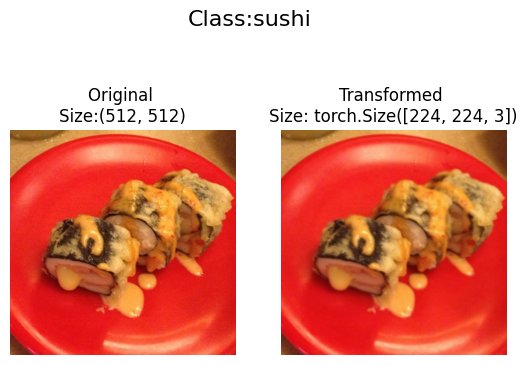

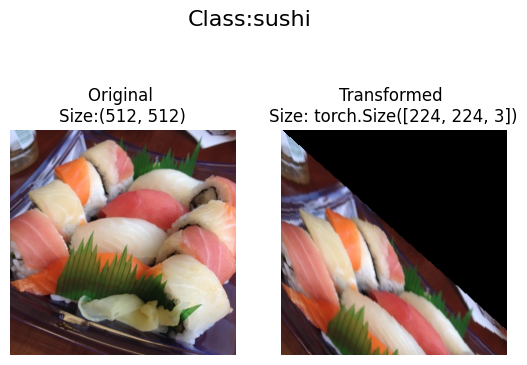

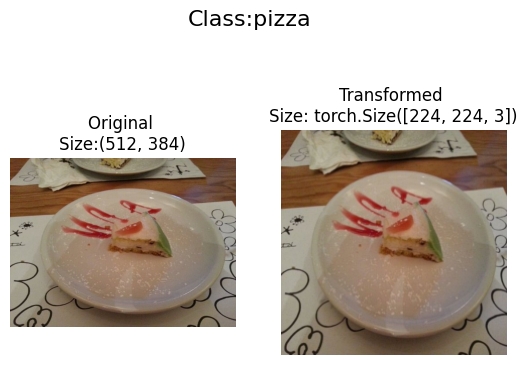

In [20]:
#test the data augmentation created out
#obtain image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#plotting random images
plot_transformed_images(image_paths=image_path_list, transform=train_transforms,n=3,seed=None)

7. Model0: TinyVGG without data augmentation


create a computer vision model to classify if an image is of steak,pizza or sushi

In [21]:
#creating transforms
simple_transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

In [22]:
#1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,transform= simple_transform)
#2. turn data into dataloaders
import os
from torch.utils.data import DataLoader

#setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size: {BATCH_SIZE} and {NUM_WORKERS} workers")
#create dataloader'set
train_dataloader_simple = DataLoader(train_data_simple, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers= NUM_WORKERS)
train_dataloader_simple, test_dataloader_simple


Creating DataLoader's with batch size: 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x1ca7ea71a50>,
 <torch.utils.data.dataloader.DataLoader at 0x1ca7e462050>)

In [23]:
#7.2 create TinyVGG model class
class TinyVGG(nn.Module):
    def __init__(self,input_shape:int, hidden_units:int, output_shape:int) ->None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, #size of the square that's going over the image
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x=self.conv_block_1(x)
        #printing x.shape
        x= self.conv_block_2(x)
        x=self.classifier(x)
        return x #return self.classifier(self.conv_block_2(self.conv_block_1(x))
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, #number of color channels 3 for RGB
                  hidden_units=10,
                  output_shape=len(train_data.classes))
model_0             

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [24]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single)
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [25]:
#A forward pass on a single image (model test)
#get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))
#2. get a single image from the batch and unsqueeze the image so its shape  fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape} \n")

#3. perfom a forward pass 
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single)
#4 print out progress and convert model logits -> pred probs ->pred label
print(f"Output logits: \n{pred}\n")
print(f"Output prediction probabilities: \n{torch.softmax(pred,dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")




Single image shape: torch.Size([1, 3, 64, 64]) 

Output logits: 
tensor([[0.0637, 0.0615, 0.0382]])

Output prediction probabilities: 
tensor([[0.3364, 0.3357, 0.3279]])

Output prediction label:
tensor([0])

Actual label:
1


In [26]:
#7.4 using torchinfo  to get idea of the shapes going through the model
!pip install torchinfo

In [27]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#7.5 Create train and test loop functions


functionize training and testing loops

1. train_step() takes in a model a dataloader, a loss function and an optimizer and trains the model on the dataloader

2. test_step() takes in a model , a dataloader and a loss function and evaluates the model on the dataloader

3. train() performs 1 and 2 together for a given number of epochs and returns a results dictionary


In [29]:
#Building a train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    #setting up train loss and train accuracy values
    train_loss, train_acc =0, 0
    #loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):

        #1. forward pass
        y_pred = model(X)
        #2.calc and accumalate loss
        loss =loss_fn(y_pred, y)
        train_loss += loss.item()
        #3. Optimizer.zer_grad()
        optimizer.zero_grad()
        #4. loss backward
        loss.backward()
        #5. optimizer step
        optimizer.step()
        #calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    #adjust metrics to get average loss and accuracy per batch
    train_loss= train_loss/len(dataloader)
    train_acc= train_acc/len(dataloader)
    return train_loss, train_acc




In [70]:
#<<the more we both stuck together, the more  our outside layers fell off, revealing all our insecurities, fears and dreams.>>>

In [40]:
####<<<<<>>>>>>>>
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X, y
            #X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() /
                         len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [41]:
########<<<<<<>>>>>>
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [43]:
####3###<<<<<<<<<>>>>>>>>>>>
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))#.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [02:17<09:08, 137.07s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604


 40%|████      | 2/5 [03:37<05:11, 103.86s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979


 60%|██████    | 3/5 [04:57<03:05, 92.80s/it] 

Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979


 80%|████████  | 4/5 [07:13<01:50, 110.09s/it]

Epoch: 4 | train_loss: 1.0989 | train_acc: 0.4141 | test_loss: 1.1343 | test_acc: 0.1979


100%|██████████| 5/5 [08:39<00:00, 103.87s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 519.382 seconds


In [ ]:
#Building a test_step function
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    #putting the model nto training mode
    model.eval()
    #setting test_loss and test accuracy values
    test_loss, test_data= 0, 0#######
    #turning on inference context manager
    with torch.inference_mode():
        #loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #

            #1. Forward pass
            test_pred_logits = model(X)

            #2. calculate and accumulate loss
            loss= loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            #calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            # adjusting metrics to get average loss and accuracy per batch
            test_loss = test_loss / len(dataloader)
            test_acc =  test_acc/ len(dataloader)
    return test_loss, test_acc




7.6 Creating a train() function to compile train_step() and test_step()


To put train_step() and test_step() functions together, you package them up in a train() function. The function will train the model as well as evaluate.
Specifically:
    1. take in a model, a DataLoader for training and test sets, an optimizer, a loss function and epochs to perform each train and test step for.

    2. create an empty results dictionary for train_loss, train_accc, test_loss and test_acc values

    3. loop through the training and test step function for a number of epochs

    4.print out what's happening at the end of each epoch.

    5.update the empty results dictionary with the updated metrics each epoch

    5.return the filled.



tqdm progress bar library, keeps track of the number of epochs you've been through.

In [33]:
#<<>>
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [38]:
from tqdm.auto import tqdm
#1. take in various parameters required for training and test steps
def train(model:torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs:int = 5):
    #.create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc": []
               }
    #3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)
        test_loss, test_acc=test_step(model=model, dataloader= test_dataloader, loss_fn=loss_fn)
        
        #test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        #4.print out what's happening
        print(f"Epoch:{epoch+1} |"
        f"train_loss: {train_loss:.4f}|"
        f"train_acc:{train_acc:.4f}|"
        f"test_loss:{test_loss:.4f}|"
        f"test_acc:{test_acc:.4f}"
        )
        #5 update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    #6.Return the filled results at the end of the epochs
    return results
    

7.7 Train and Evaluate Model 0


In [ ]:
#torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5
#recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,#number of color channels(3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes))
#loss function and optimizer setup
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
#starting the timer
from timeit import default_timer as timer
start_timer = timer()
#training model_0
model_0_results = train(model=model_0, train_dataloader = train_dataloader_simple,
test_dataloader =test_dataloader_simple,optimizer=optimizer,loss_fn = loss_fn,epochs=NUM_EPOCHS)
#end timer and printout time taken
end_timer = timer()
print(f"Total training: {end_timer - start_timer:.3f} seconds")


7.8 #Plotting the loss curves of Model 0


loss curves shows the model performance over time


In [44]:
#checking model 0 key results
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [52]:
from typing import Dict, List

In [54]:
#next is to extract each of the keys above and turn them into a plot
def plot_loss_curves(results: Dict[str, List[float]]):
    #getting the loss values of the rsults dict(training &test)
    loss=results["train_loss"]
    test_loss = results['test_loss']

    #accuracy values of the results dict
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    #check how many epochs were there
    epochs = range(len(results['train_loss']))

    #
    plt.figure(figsize=(15,7))
    #plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss, label='test_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()

    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy, label='train_acccuracy')
    plt.plot(epochs,test_accuracy,label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();



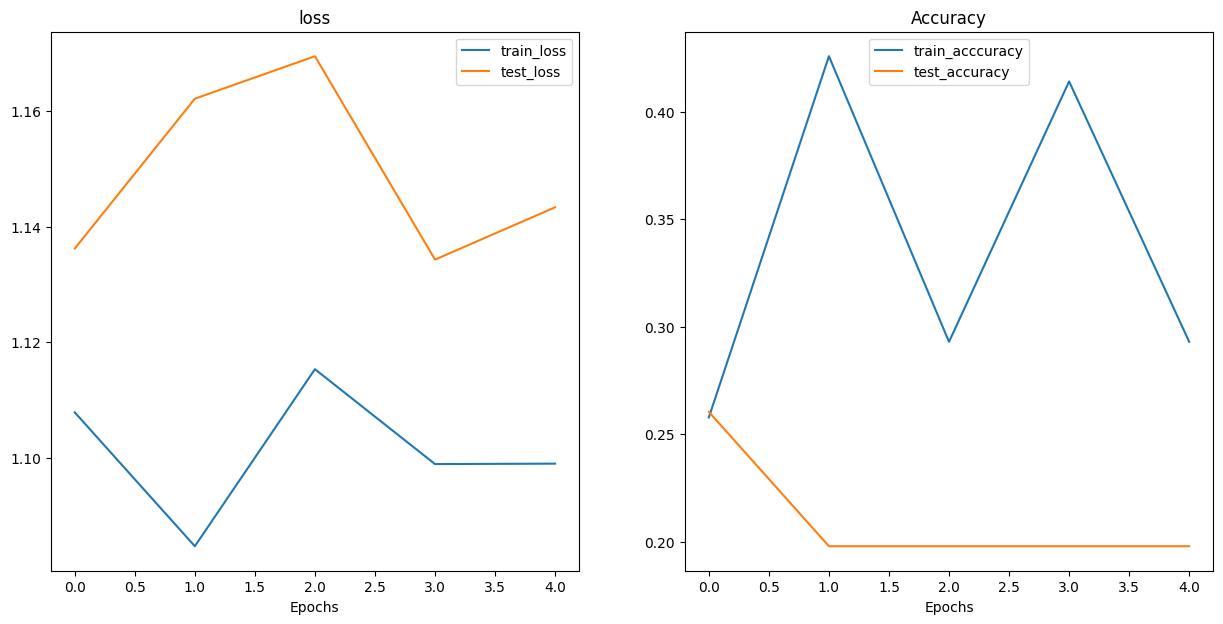

In [55]:
plot_loss_curves(model_0_results)

8.0 #Ideal loss curve



An overfitting model performs better on the training set than the validation/test set. So if training loss is far lower than the test loss then the model is overfitiing. This is to say,the model is learning the patterns in the training too well but those patterns aren't generalizing to the test data.


An undefitting model is when the training and test loss are not as low as you'd like.

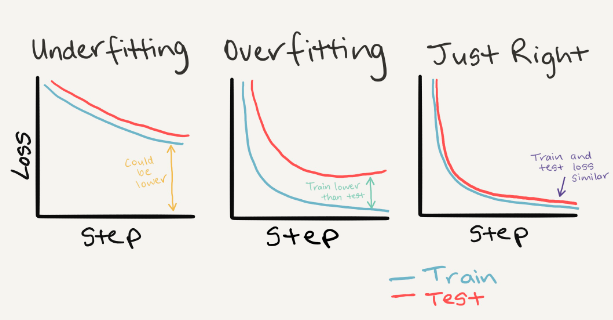

##Dealing with overfitting
